In [1]:
import argparse
import torch
import os
import os.path as osp
import json
from tqdm import tqdm
import threading
import pandas as pd
import numpy as np
import base64
import io
import random
import shortuuid
from llava.serve.classes.Compiler import *
import sys
import argparse
from llava.serve.classes.Utils import *
from llava.serve.classes.Compiler import *


os.chdir("/ossfs/node_32682640/workspace/MFTCoderVL/MFTCoderVL/")

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model, load_pretrained_model_custom_proj, load_mixed_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria

from PIL import Image
import math

def render_content_with_text(key, value):
    if FILL_WITH_RANDOM_TEXT:
        if key.find("btn") != -1:
            value = value.replace(TEXT_PLACE_HOLDER, Utils.get_random_text())
        elif key.find("title") != -1:
            value = value.replace(TEXT_PLACE_HOLDER, Utils.get_random_text(length_text=5, space_number=0))
        elif key.find("text") != -1:
            value = value.replace(TEXT_PLACE_HOLDER,
                                  Utils.get_random_text(length_text=56, space_number=7, with_upper_case=False))
    return value

FILL_WITH_RANDOM_TEXT = True
TEXT_PLACE_HOLDER = "[]"

disable_torch_init()
model_path = "/mnt/project/LLAVA/visual_tuning_weights/qwen-vl-14b-lora-sft-1224/checkpoint-17000/"
model_base = "/mnt/user/laiyan/salesgpt/model/Qwen-14B-Chat-VL/"
model_name = "qwen-14b-lora"
vision_tower = "/mnt/project/LLAVA/Qwen-VL-visual/"
mm_projector_type = "cross_attn"
mm_projector = "/mnt/project/LLAVA/pretrain_weights/qwen-vl-14b-cross-attn-1126-multigpu/checkpoint-9000/mm_projector.bin"
tokenizer, model, image_processor, context_len = load_mixed_pretrained_model(model_path, model_base, model_name, vision_tower, mm_projector_type, mm_projector)
compiler = Compiler("/ossfs/node_32682640/workspace/MFTCoderVL/MFTCoderVL/llava/serve/assets/web-dsl-mapping.json")


tokenizer.pad_token_id = tokenizer.eod_id
model = model.cuda()

image_fn = "/mnt/project/LLAVA/image2schema_data/sft_data/sketch2code/sketch2code_data/00779BBE-DD64-4909-9909-24F5C8044A7B.png"


im_start = torch.tensor(tokenizer.im_start_id)  ##每次对话起始符，无论用户还是机器
im_end = torch.tensor(tokenizer.im_end_id)  ##每次对话起始符，无论用户还是机器
nl_tokens = torch.tensor(tokenizer('\n').input_ids)
system = torch.tensor(tokenizer('system').input_ids)  ##全样本就一个的system
_user = torch.tensor(tokenizer('user').input_ids)
_assistant = torch.tensor(tokenizer('assistant').input_ids)

def inference(prompt, image):
    inputs = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
    prompt = "<|im_start|>user\n" + "Picture 1:<img></img>\n" + prompt + "<|im_end|>\n" + "<|im_start|>assistant\n"
    inputs += prompt

    tokens = tokenizer(
        inputs,
        max_length=tokenizer.model_max_length,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
    input_ids = tokens.input_ids.cuda()

    stop_str = tokenizer.pad_token
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).cuda(),
            do_sample=True,
            temperature=0.2,
            top_p=0.3,
            top_k=0,
            max_new_tokens=2048,
            return_dict_in_generate=False,
            use_cache=True)
    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(f'[Warning] {n_diff_input_output} output_ids are not the same as the input_ids')
    output_text = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
    return output_text


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type qwen to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.
2024-01-09 13:53:21,138 - llava.model.language_model.qwen.modeling_qwen - WARNING - The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".


Loading LLaVA from base model...


Loading checkpoint shards: 100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...
Loading MM projector....
PROJECTOR TYPE:  cross_attn
MM projector Loaded


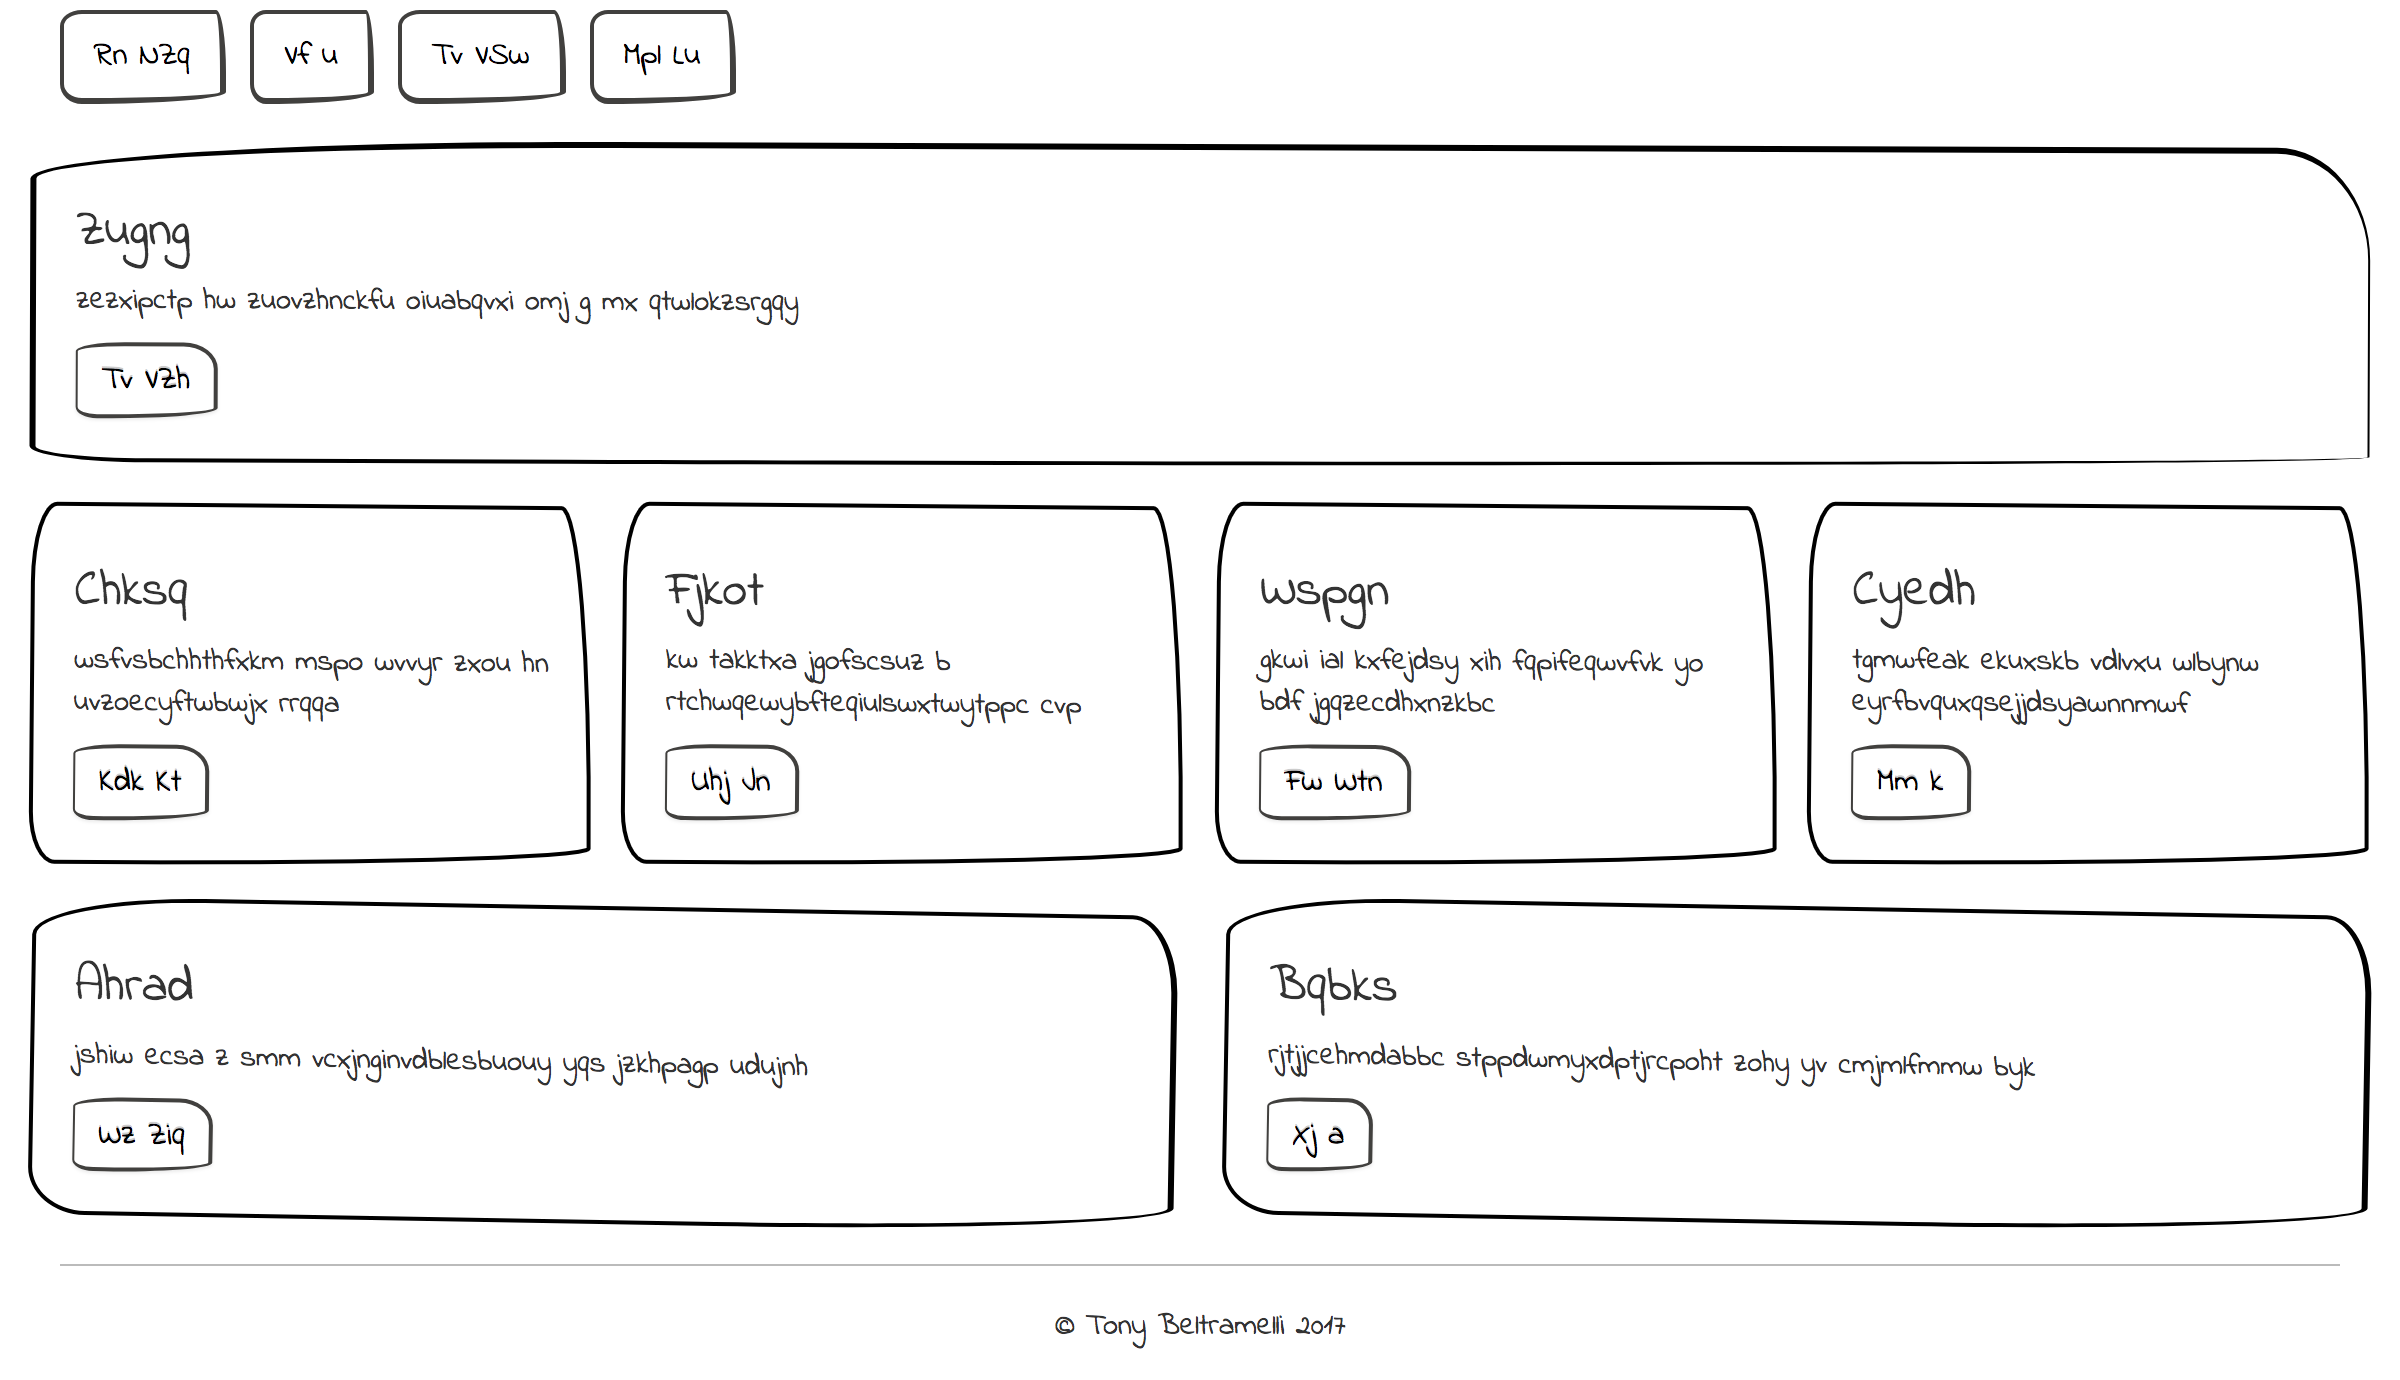

In [2]:
image = Image.open(image_fn).convert('RGB')
image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
image.show()

In [3]:
prompt = "Please generate DSL for the skect on this image:\n"

output_text = inference(prompt, image)

print(output_text)

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}




In [4]:
output_text = output_text.replace("<|im_end|>", "").replace("<|im_start|>", "").replace("\n", "")
output_text = output_text.lower()
output_text = output_text.replace("{", "{\n").replace("}", "\n}\n").replace("\n\n", '\n').rstrip("\n")


output_html = compiler.compile(output_text, None, rendering_function=render_content_with_text)
print(output_html)

<html>
  <header>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css" integrity="sha384-BVYiiSIFeK1dGmJRAkycuHAHRg32OmUcww7on3RYdg4Va+PmSTsz/K68vbdEjh4u" crossorigin="anonymous">
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap-theme.min.css" integrity="sha384-rHyoN1iRsVXV4nD0JutlnGaslCJuC7uwjduW9SVrLvRYooPp2bWYgmgJQIXwl/Sp" crossorigin="anonymous">
<style>
.header{margin:20px 0}nav ul.nav-pills li{background-color:#333;border-radius:4px;margin-right:10px}.col-lg-3{width:24%;margin-right:1.333333%}.col-lg-6{width:49%;margin-right:2%}.col-lg-12,.col-lg-3,.col-lg-6{margin-bottom:20px;border-radius:6px;background-color:#f5f5f5;padding:20px}.row .col-lg-3:last-child,.row .col-lg-6:last-child{margin-right:0}footer{padding:20px 0;text-align:center;border-top:1px solid #bbb}
</style>
    <title>Scaffol